In [18]:
from skimage import io, transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
import pandas
from dataLoader import OrganoidDataset
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [20]:
from skimage import io, transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import sys
import pandas
from dataLoader import OrganoidDataset


In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 20, # low for testing
          'shuffle': True, 'num_workers' : 1}
max_epochs = 20

In [22]:
path = '../data/CS231n_Tim_Shan_example_data/'


In [23]:
well_descriptions = pandas.read_csv('../data/well_summary_A1_e0891BSA_all.csv', sep=',', header=0) # need to change name


In [24]:
well_descriptions.head(5)

,well id,day,median pixel intensity,mw_area shape,hyst1 area,hyst2 area
0,0,0,125.0,7830,512,418
1,1,0,125.0,8265,3044,3008
2,2,0,127.0,8280,30,0
3,3,0,128.0,8096,121,0
4,4,0,128.0,8544,82,0


In [25]:
day0wells = well_descriptions[(well_descriptions['day'] == 0)]
day13wells = well_descriptions[(well_descriptions['day'] == 13)]
finalSizes = day13wells['mw_area shape']
well_labels = []

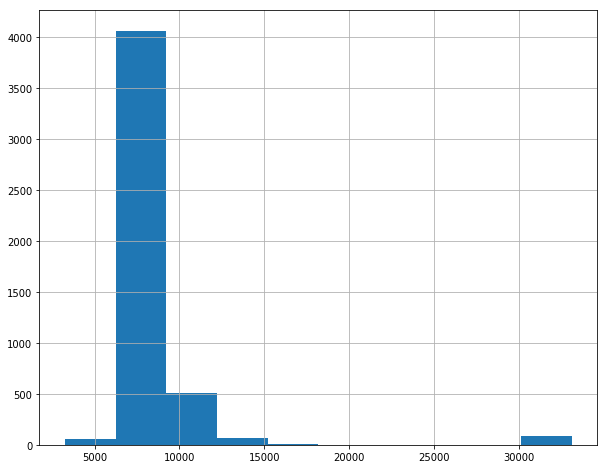

In [26]:
finalSizes.hist()

In [27]:
for i in range(4800):
  i2str = str(i)
  if len(i2str) == 1:
    i2str = '000' + i2str
  if len(i2str) == 2:
    i2str = '00' + i2str
  if len(i2str) == 3:
    i2str = '0' + i2str
  well_labels.append(i2str)

In [28]:
initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels, day_label_X = ['00']*4800, sizes = finalSizes)
training_generator = data.DataLoader(initial_train_set, **params)

In [29]:

# NUM_TRAIN = 49000
# loader_train = DataLoader(training_generator, batch_size=64, 
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

In [30]:
image_size = 193
in_channel = 4
output_channel = 1

In [31]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [32]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),   
    Flatten(),
    nn.Linear(channel_2*image_size*image_size, output_channel,bias=True),
)

In [33]:
model = model.to(device=device)

In [34]:
epochs=1

In [ ]:
# for epoch in range(max_epochs):
#   # Training
#   optimizer.zero_grad()
#   totalbatchMSE = 0.0
#   for local_X, local_Y in training_generator:
#     local_X, local_Y = local_X.to(device), local_Y.to(device)
#     Y_hat = model.run_all_forward(local_X)
#     train_error = loss(Y_hat, local_Y)
#     train_error.backward()
#     optimizer.step()
#     model.eval() # set evaluation mode
#     Y_hat = model.run_all_forward(local_X)
#     train_error = loss(Y_hat, local_Y).item()
#     totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/4800 # rescale train_error
#     train_error_array[epoch] = totalbatchMSE

In [35]:
train_errors = {}
for e in range(epochs):
    totalbatchMSE = 0.0
    for x, y in training_generator:
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        Y_hat = model(x)
        loss = nn.MSELoss(Y_hat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/4800
        train_errors[e] = totalbatchMSE

KeyError: 'Traceback (most recent call last):\n  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/home/shanzhou/OrganoidNet/models/dataLoader.py", line 32, in __getitem__\n    y = self.getYsize(index)\n  File "/home/shanzhou/OrganoidNet/models/dataLoader.py", line 29, in getYsize\n    return self.sizes[index]\n  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 767, in __getitem__\n    result = self.index.get_value(self, key)\n  File "/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3118, in get_value\n    tz=getattr(series.dtype, \'tz\', None))\n  File "pandas/_libs/index.pyx", line 106, in pandas._libs.index.IndexEngine.get_value\n  File "pandas/_libs/index.pyx", line 114, in pandas._libs.index.IndexEngine.get_value\n  File "pandas/_libs/index.pyx", line 162, in pandas._libs.index.IndexEngine.get_loc\n  File "pandas/_libs/hashtable_class_helper.pxi", line 958, in pandas._libs.hashtable.Int64HashTable.get_item\n  File "pandas/_libs/hashtable_class_helper.pxi", line 964, in pandas._libs.hashtable.Int64HashTable.get_item\nKeyError: 1089\n'

In [ ]:
print(loss)

In [3]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [4]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),   
    Flatten(),
    nn.Linear(channel_2*32*32, 10,bias=True),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
pass